# Replication - High Dimensional Case Figure

Here we provide a notebook to replicate the high-dimensional simulation figure.

The notebook replicates the results in:
- /out/simulation/figures/hd.eps

The main script can be found at: 
- /scripts/simulation/figures/hd.py



In [ ]:
!pip3 install probcox 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 614kB 32.5MB/s 
  Created wheel for probcox: filename=probcox-0.0.5-cp37-none-any.whl size=5226 sha256=3328890c498e41bf92cf0623f696101946c31efae51a73ca5d2e74266f2553c6
  Stored in directory: /root/.cache/pip/wheels/7a/ed/e5/71cb95c54c96702f1412114114806c74394f421b6cbda6af70
Successfully built probcox


In [ ]:
# Modules
# =======================================================================================================================

import os
import sys
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

np.random.seed(5256)
torch.manual_seed(9235)

# Setup
# =======================================================================================================================
small_plot = True # sub-sample 0 parameters - otherwise figure gets too large

suffix = 'rank50_b1024' # rank5, rank50, rank50_b1024  - either Multivariate Normal with rank 5, or 50 and one with MN rank 50 and batch size 1024
R_suffix = '_1se' # '' for the lambda minimum version or '_1se' for the lamdba 1se version


In [ ]:
# Funtion
# =======================================================================================================================
def custom_mean(X, W, col_idx):
    '''
    - average for paramters of an array selcted by an indexing matrix

    X :: array to apply mean along axis=0
    W :: indexing which elements to use for mean computatiuon
    col_idx :: indexing the columns where W is applied - otherwise standard mean without selecting elements
    '''
    m = []
    assert X.shape == W.shape
    N, M = X.shape

    for jj in range(M):
        if col_idx[jj] == True:
            m.append(np.mean(X[W[:, jj], jj]))
        else:
            m.append(np.mean(X[:, jj]))
    return(np.asarray(m))


In [ ]:
# Plot Settings
# =======================================================================================================================

plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False



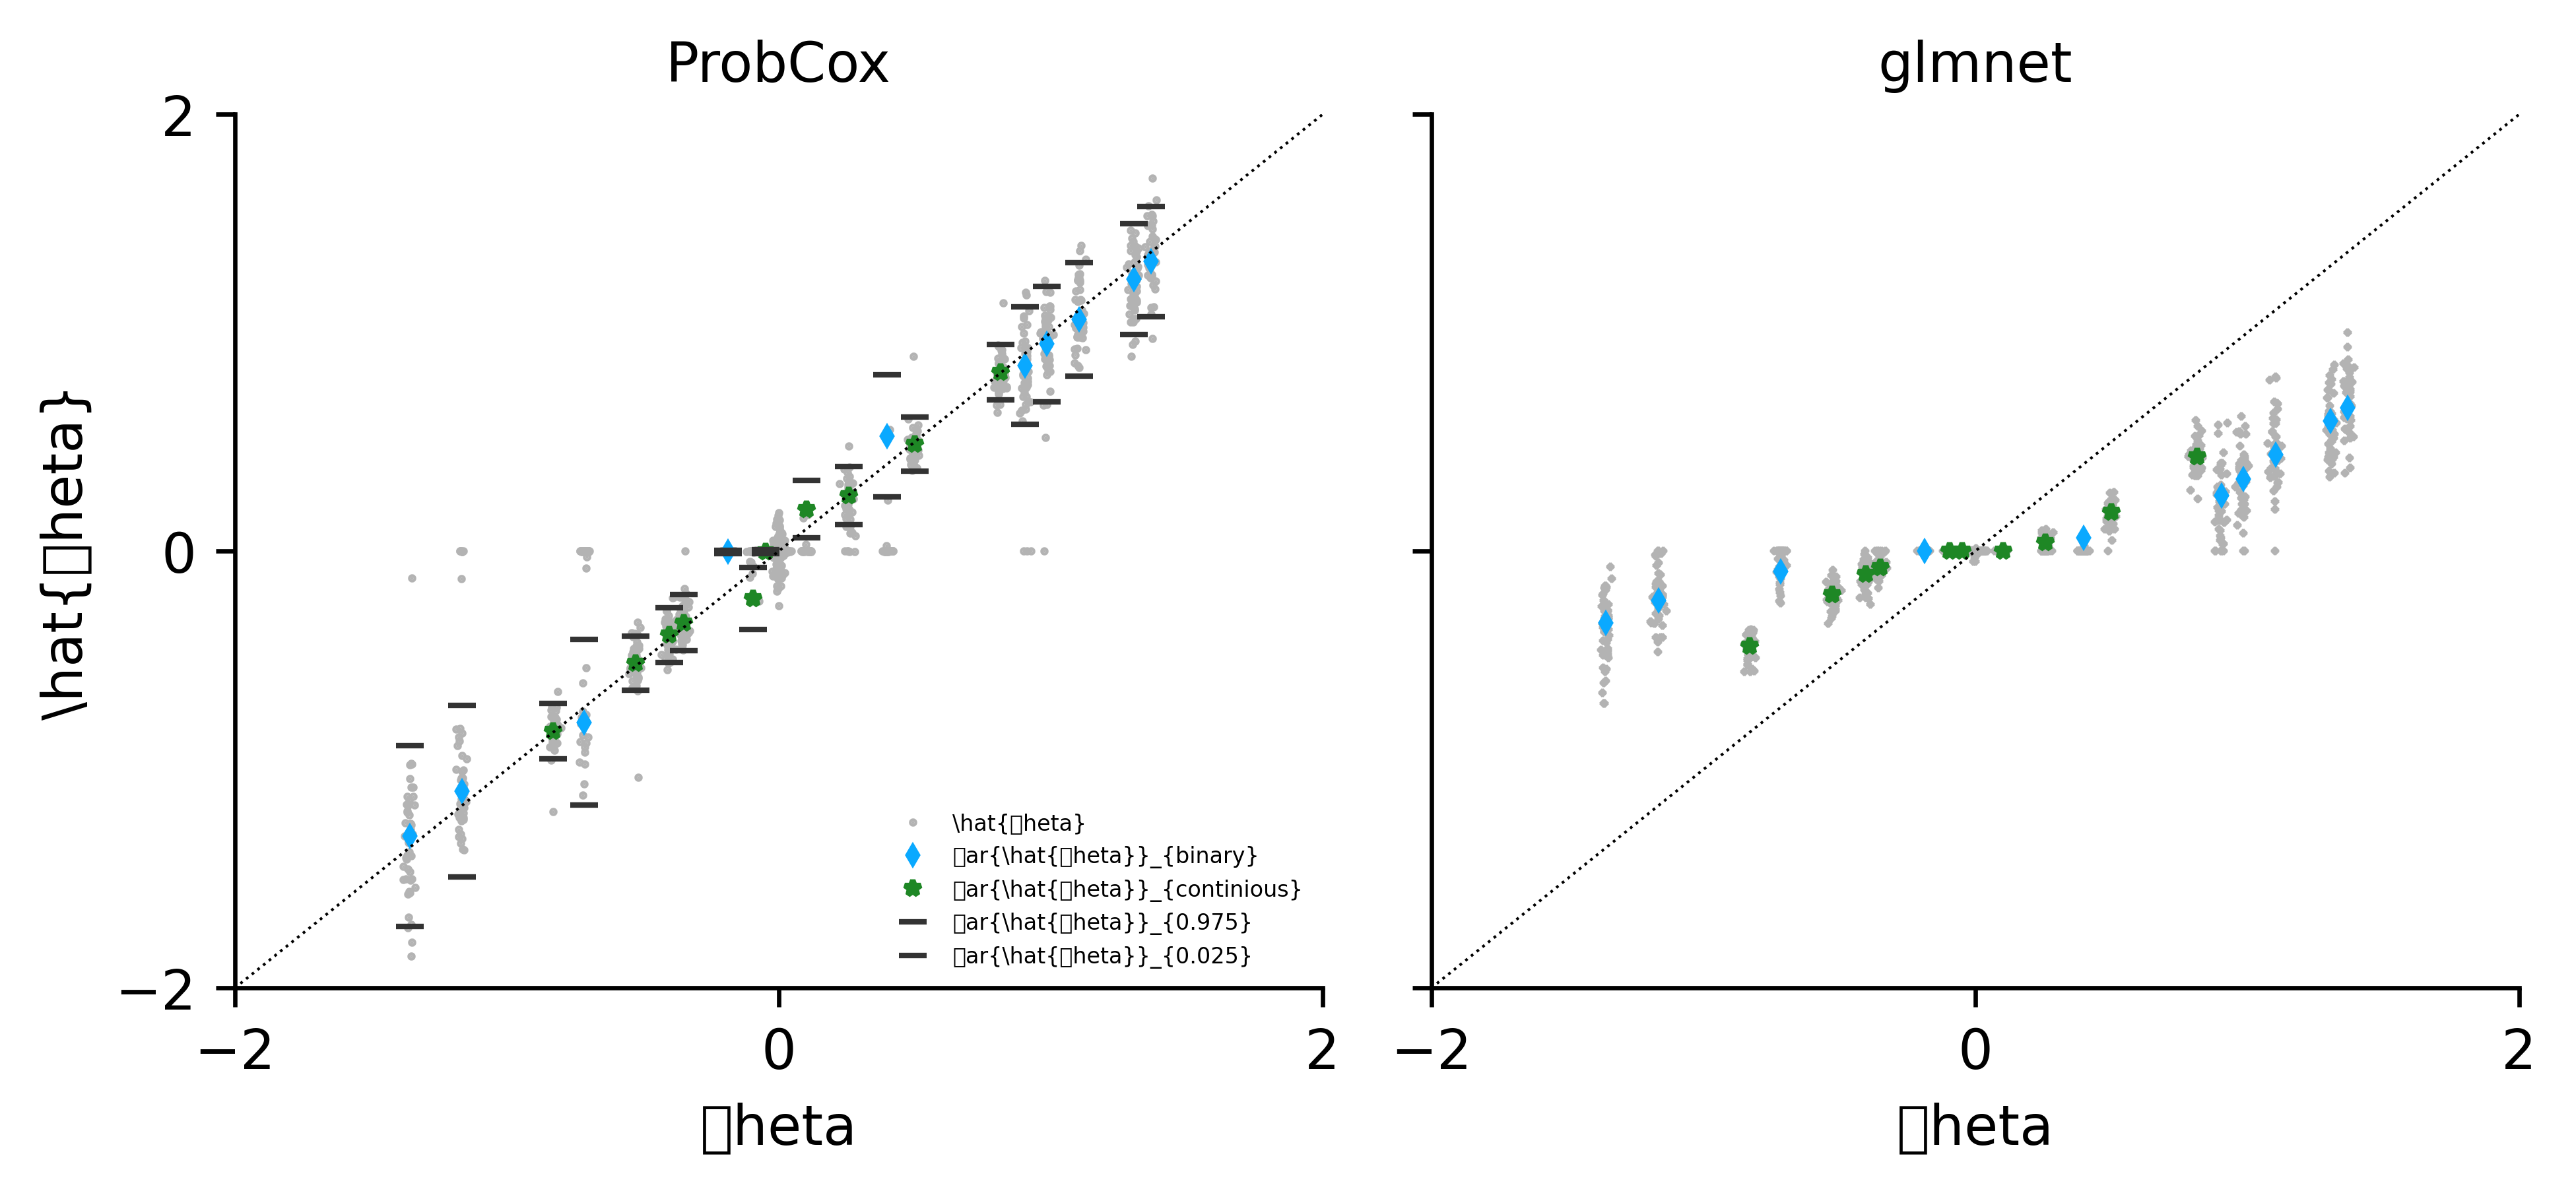

In [ ]:
# Plot
# =======================================================================================================================

url = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/theta.txt'
theta = np.asarray(pd.read_csv(url, header=None, sep=';'))

fig, ax = plt.subplots(1, 2, figsize=(8.27*0.90, 11.69/4), dpi=600, sharey=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)


url1 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/probcox' + suffix +'_theta.txt'
url2 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/probcox' + suffix +'_theta_lower.txt'
url3 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/probcox' + suffix +'_theta_upper.txt'


theta_est = pd.read_csv(url1, header=None, sep=';')
theta_est_lower = pd.read_csv(url2, header=None, sep=';')
theta_est_upper = pd.read_csv(url3, header=None, sep=';')

theta_est = theta_est.dropna(axis=0)
theta_est = theta_est.groupby(0).first().reset_index()
theta_est = theta_est.iloc[:, 1:-1]
theta_est = np.asarray(theta_est).astype(float)

theta_est_lower = theta_est_lower.dropna(axis=0)
theta_est_lower = theta_est_lower.groupby(0).first().reset_index()
theta_est_lower = theta_est_lower.iloc[:, 1:-1]
theta_est_lower = np.asarray(theta_est_lower).astype(float)

theta_est_upper = theta_est_upper.dropna(axis=0)
theta_est_upper = theta_est_upper.groupby(0).first().reset_index()
theta_est_upper = theta_est_upper.iloc[:, 1:-1]
theta_est_upper = np.asarray(theta_est_upper).astype(float)

if small_plot:
    non_zeros = 250
    idx = np.concatenate((np.arange(10), np.arange(5000, 5010), np.random.choice(np.arange(10, 5000), non_zeros, replace=False)
    , np.random.choice(np.arange(5010, 10000), non_zeros, replace=False)
    ))
    theta = theta[idx, :]
    theta_est = theta_est[:, idx]
    theta_est_lower = theta_est_lower[:, idx]
    theta_est_upper = theta_est_upper[:, idx]


for _ in range(50):
    ax[0].plot(theta + np.random.normal(0, 0.01, (theta.shape[0], 1)), theta_est[_, :], ls='', marker='.', ms=1, c='.7')
ax[0].plot(theta + np.random.normal(0, 0.01, (theta.shape[0], 1)), theta_est[0, :], ls='', marker='.', ms=1, c='0.7', label='\hat{\theta}')


W = np.sign(theta_est_lower) == np.sign(theta_est_upper) # non zero parameters estimates (based on HPD95%)
col_idx = np.logical_and(np.squeeze(theta != 0), np.sum(W, axis=0) > 5) # true non-zero parameters



ax[0].plot(theta[:10], custom_mean(theta_est, W, col_idx)[:10], ls='', marker='d', ms=2, c='#0aa9ff', label='\bar{\hat{\theta}}_{binary}')
ax[0].plot(theta[10:20], custom_mean(theta_est, W, col_idx)[10:20], ls='', marker='*', ms=3, c='#1e8725', label='\bar{\hat{\theta}}_{continious}')


ax[0].plot(theta[:20], custom_mean(theta_est_lower, W, col_idx)[:20], ls='', marker='_', ms=5, c='.2', label='\bar{\hat{\theta}}_{0.975}')
ax[0].plot(theta[:20], custom_mean(theta_est_upper, W, col_idx)[:20], ls='', marker='_', ms=5, c='.2', label='\bar{\hat{\theta}}_{0.025}')



ax[0].set(xlim=(-2, 2), ylim=(-2, 2))
ax[0].set_xlabel('\theta')
ax[0].set_ylabel('\hat{\theta}')
ax[0].set_yticks([-2, 0, 2])
ax[0].set_ylim([-2, 2])
ax[0].set_xticks([-2, 0, 2])
ax[0].set_xlim([-2, 2])
ax[0].plot(ax[0].get_xlim(), ax[0].get_ylim(), ls=':', color='black', linewidth=0.5)
ax[0].set_title('ProbCox', fontsize=10)


# glmnet
url = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/R_theta_1se.txt'
theta_est = pd.read_csv(url, header=None, sep=';')

theta_est = theta_est.dropna(axis=0)
theta_est = theta_est.groupby(0).first().reset_index()
theta_est = np.asarray(theta_est.iloc[:, 1:])

if small_plot:
    theta_est = theta_est[:, idx]

for _ in range(50):
    ax[1].plot(theta + np.random.normal(0, 0.01, (theta.shape[0], 1)), theta_est[_, :], ls='', marker='x', ms=1, c='.7')
ax[1].plot(theta + np.random.normal(0, 0.01, (theta.shape[0], 1)), theta_est[0, :], ls='', marker='x', ms=1, c='.7', label='\hat{\theta}')

W = theta_est!=0 # non zero parameters estimates (based on HPD95%)
col_idx = np.logical_and(np.squeeze(theta != 0), np.sum(W, axis=0) > 5) # true non-zero parameters

ax[1].plot(theta[:10], custom_mean(theta_est, W, col_idx)[:10], ls='', marker='d', ms=2, c='#0aa9ff')
ax[1].plot(theta[10:20], custom_mean(theta_est, W, col_idx)[10:20], ls='', marker='*', ms=3, c='#1e8725')


ax[1].set(xlim=(-2, 2), ylim=(-2, 2))
ax[1].set_xlabel('\theta')
ax[1].set_ylabel('')
ax[1].set_yticks([-2, 0, 2])
ax[1].set_ylim([-2, 2])
ax[1].set_xticks([-2, 0, 2])
ax[1].set_xlim([-2, 2])
ax[1].plot(ax[1].get_xlim(), ax[1].get_ylim(), ls=':', color='black', linewidth=0.5)
ax[0].legend(frameon=False, prop={'size': 4}, loc='lower right')
ax[1].set_title('glmnet', fontsize=10)

plt.show()
plt.close()